# SEA-POL low-level gridded rain rate

Level 4v1.2

/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.2/PICCOLO_level4_rainrate_2D.nc

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

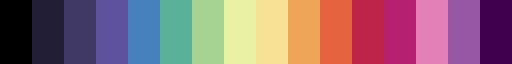

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

In [5]:
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.2/PICCOLO_level4_rainrate_2D.nc')
seapol

<xarray.Dataset> Size: 50GB
Dimensions:          (time: 8587, Y: 491, X: 491)
Coordinates:
  * X                (X) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
  * Y                (Y) float32 2kB -2.45e+05 -2.44e+05 ... 2.44e+05 2.45e+05
    latitude         (time, Y, X) float32 8GB ...
    longitude        (time, Y, X) float32 8GB ...
  * time             (time) datetime64[ns] 69kB 2024-08-16T08:10:00 ... 2024-...
Data variables:
    DBZ              (time, Y, X) float32 8GB ...
    HID              (time, Y, X) float32 8GB ...
    RAINRATE         (time, Y, X) float32 8GB ...
    elevation_angle  (time, Y, X) float32 8GB ...
    grid_mapping     int32 4B ...
    heading          (time) float32 34kB ...
    start_time       (time) datetime64[ns] 69kB ...
    stop_time        (time) datetime64[ns] 69kB ...
Attributes: (12/15)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    project:           PICCOLO, BOWTIE, ORCESTRA
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    history:           v1.2

Temporary fixes due to duplicated and re-ordered data

In [6]:
#Remove duplicate data
seapol = seapol.sel(time=~seapol.get_index('time').duplicated())

In [7]:
#Reorder mis-ordered data
seapol = seapol.sortby('time')

In [8]:
# Mask out missing data (-32769 = no data possible) actually - xarray already sets these to NaN
# the lowest non-nan value it finds for dbz is -9999 (data possible but removed during QC)
# So all I will do here is just rename the variables for easier access
rainrate = seapol.RAINRATE
dbz = seapol.DBZ

In [9]:
# Change -9999 missing data to zeros for rainrate, NaN for dbz (data possible but removed = "not raining" though technically could be below beam) 
rainrate2 = rainrate.where(rainrate != -9999., 0)
#dbz2 = dbz
dbz2 = dbz.where(rainrate != -9999., np.nan)

In [10]:
#Check for bad data

ihigh = np.where(rainrate2 > 300)
ihigh

(array([  15,   26,   76,   76,   76,   76,   77,  265,  265,  271,  274,
         278,  278,  279,  286,  291,  527, 5755]),
 array([262, 263, 272, 272, 273, 274, 273, 275, 276, 262, 254, 246, 246,
        245, 230, 230, 284, 243]),
 array([254, 273, 293, 294, 293, 293, 293, 247, 247, 236, 231, 224, 225,
        224, 220, 218, 235, 243]))

In [11]:
#Print out the bad data

for i in range(len(ihigh[0])):
    print(f"Rainrate: {rainrate2[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values} mm/h with {dbz2[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values} dBZ at time {seapol.time[ihigh[0][i]].values} and lat/lon {seapol.latitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}, {seapol.longitude[ihigh[0][i],ihigh[1][i],ihigh[2][i]].values}")



Rainrate: 386.03155517578125 mm/h with 61.425445556640625 dBZ at time 2024-08-16T09:35:00.000000000 and lat/lon 16.80080223083496, -24.931440353393555
Rainrate: 1010.134765625 mm/h with 65.02999877929688 dBZ at time 2024-08-16T10:30:00.000000000 and lat/lon 16.668071746826172, -24.68763542175293
Rainrate: 330.14825439453125 mm/h with 59.4813346862793 dBZ at time 2024-08-16T21:35:00.000000000 and lat/lon 14.996846199035645, -23.71830940246582
Rainrate: 330.14825439453125 mm/h with 59.4813346862793 dBZ at time 2024-08-16T21:35:00.000000000 and lat/lon 14.996827125549316, -23.70901107788086
Rainrate: 527.5956420898438 mm/h with 63.2377815246582 dBZ at time 2024-08-16T21:35:00.000000000 and lat/lon 15.00588321685791, -23.718290328979492
Rainrate: 327.31756591796875 mm/h with 61.45665740966797 dBZ at time 2024-08-16T21:35:00.000000000 and lat/lon 15.014920234680176, -23.718271255493164
Rainrate: 380.9399108886719 mm/h with 59.20687484741211 dBZ at time 2024-08-16T21:40:00.000000000 and lat/

In [12]:
# Also mask out data with unrealistically high rain rates. This is a science decision -- the reflectivities are valid, 
# so it is a real echo [unless a few remaining land points snuck in], but probably is ice or hail so shouldn't really have a valid rainrate
# set to zero (like saying there is no echo)
rainrate3 = rainrate2.where((rainrate2 <= 1000) | (rainrate2.isnull()), 0) # keep nans
dbz3 = dbz2.where((rainrate2 <= 1000) | (dbz2.isnull()), np.nan)
rainrate4 = rainrate3.where((rainrate3 <= 300) | (rainrate3.isnull()), 0)
dbz4 = dbz3.where((rainrate3 <= 300) | (dbz3.isnull()), np.nan)

# or don't
#rainrate4 = rainrate2
#dbz4 = dbz2

### Take spatial average precipitation and precipitation intensity at each available time

Extract just the long range scans to ONLY take the average within 245 km over those scans

In [13]:
#code from Sarah Kennison
# use x and y to calculate a grid and get each grid point's distance from array center
X, Y = np.meshgrid(seapol.X.values, seapol.Y.values)
center_x = np.nanmean(X)
center_y = np.nanmean(Y)
distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

# mask out anything past 130 km (130000 meters) [a bit further than 120 km just to be safe]
outer_mask = distance_from_center > 130000

# define 8 sections of 45 degrees each
num_sections = 8
angles = np.arctan2(Y - center_y, X - center_x)  # radians, -pi to pi
section_edges = np.linspace(-np.pi, np.pi, num_sections + 1)

# list to store the indices of the long range scans
indices_245 = []

# loop over all scans using the dbz arrays 
for t in range(dbz.shape[0]):
    dbz_frame = dbz[t]
    dbz_vals = dbz_frame.values

    # initialize sections found to be 0 
    found_sections = 0

    # loop over the 8 sections
    for i in range(num_sections):

        # mask within angle range and > 130 km from center of array 
        section_mask = ((angles >= section_edges[i]) & (angles < section_edges[i+1]) & outer_mask)

        # check if there is any valid (non-nan, >-32768) data in this section
        section_data = dbz_vals[section_mask]
        if np.ma.isMaskedArray(section_data):
            valid = np.any(~section_data.mask & (section_data > -32768))
        else:
            valid = np.any(~np.isnan(section_data) & (section_data > -32768))
        if valid:
            found_sections += 1

    # if data found in a section, append the time index as a 245 scan 
    if found_sections > 1:
        indices_245.append(t)

In [14]:
#Spatial mean over 245 km x 245 km ** only using the identified long range scans
rain245 = rainrate4[indices_245].mean(dim=('X','Y'),skipna=True)

#Spatial mean over 120 km x 120 km
rain120 = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean over 60 km x 60 km
rain60 = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean over 12 km x 12 km
rain12 = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).mean(dim=('X','Y'),skipna=True)

#Spatial mean within 1 km
rain1 = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).mean(dim=('X','Y'),skipna=True)


In [15]:
# Conditional mean (only where rainrate > 0)
rain245cond = rainrate4.where(rainrate4>0).mean(dim=('X','Y'),skipna=True)
rain120cond = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).where(rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000))>0).mean(dim=('X','Y'),skipna=True)
rain60cond = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).where(rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000))>0).mean(dim=('X','Y'),skipna=True)
rain12cond = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).where(rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000))>0).mean(dim=('X','Y'),skipna=True)
rain1cond = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).where(rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000))>0).mean(dim=('X','Y'),skipna=True)

### Calculate fractional area coverage of precip (>0)

In [16]:
# Find number of points with rainrate > 0
rain245count = rainrate4[indices_245].where(rainrate4[indices_245]>0).count(dim=('X','Y')) #only for identified long range scans
rain120count = rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).where(rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000))>0).count(dim=('X','Y'))
rain60count = rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).where(rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000))>0).count(dim=('X','Y'))
rain12count = rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).where(rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000))>0).count(dim=('X','Y'))
rain1count = rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).where(rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000))>0).count(dim=('X','Y'))  

# Calculate fractional area coverage of precip (>0)
rain245frac = rain245count / (rainrate4[indices_245].X.size * rainrate4[indices_245].Y.size) #only for identified long range scans
rain120frac = rain120count / (rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).X.size * rainrate4.sel(X=slice(-120000,120000), Y=slice(-120000,120000)).Y.size)
rain60frac = rain60count / (rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).X.size * rainrate4.sel(X=slice(-60000,60000), Y=slice(-60000,60000)).Y.size)
rain12frac = rain12count / (rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).X.size * rainrate4.sel(X=slice(-12000,12000), Y=slice(-12000,12000)).Y.size)
rain1frac = rain1count / (rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).X.size * rainrate4.sel(X=slice(-1000,1000), Y=slice(-1000,1000)).Y.size)  

### Write out spatial averages on raw time series to file

In [17]:
#combine into one dataset
#native time array that is blank where missing data
rainrate = xr.Dataset({'rain245_mean': rain245, 'rain120_mean': rain120, 'rain60_mean': rain60, 'rain12_mean': rain12, 'rain1_mean': rain1, 
                       'rain245_int': rain245cond, 'rain120_int': rain120cond, 'rain60_int': rain60cond, 'rain12_int': rain12cond, 'rain1_int': rain1cond,
                       'rain245_frac': rain245frac, 'rain120_frac': rain120frac, 'rain60_frac': rain60frac, 'rain12_frac': rain12frac, 'rain1_frac': rain1frac})

#add attributes
rainrate.attrs['title'] = 'Spatial mean rainrate from SEA-POL long-range, low-elevation scans'
rainrate.attrs['description'] = ('Spatial means of rainrate from SEA-POL long-range, low-elevation scans at different spatial scales. '
                                 'Mean is the average over all valid data points (including zeros). '
                                 'Int (intensity) is the average over all data points where rainrate > 0.'
                                 'fa is the fractional area coverage of rainrate > 0.')
rainrate.attrs['source'] = 'SEA-POL Level4v1.2 Gridded 2D Rain Rate'
rainrate.attrs['units'] = 'mm/h'

#save to netcdf
rainrate.to_netcdf('/home/awing/orcestra/data/SEA-POL_4v1.2_rainrate_2D_spatial_means.nc')

### Pad missing data with nans so it is on a regular 5-min time grid

In [18]:
# Make regular 5-minute time series
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T16:50:00')
time5m = pd.date_range(start_time, end_time, freq='5 min')
time5m = pd.to_datetime(time5m)

# Reindex to 5-minute time series, filling missing times with NaN
rain245mean = rain245.reindex(time=time5m)
rain120mean = rain120.reindex(time=time5m)
rain60mean = rain60.reindex(time=time5m)
rain12mean = rain12.reindex(time=time5m)
rain1mean = rain1.reindex(time=time5m)

rain245int = rain245cond.reindex(time=time5m)
rain120int = rain120cond.reindex(time=time5m)
rain60int = rain60cond.reindex(time=time5m)
rain12int = rain12cond.reindex(time=time5m)
rain1int = rain1cond.reindex(time=time5m)

rain245fa = rain245frac.reindex(time=time5m)
rain120fa = rain120frac.reindex(time=time5m)
rain60fa = rain60frac.reindex(time=time5m)
rain12fa = rain12frac.reindex(time=time5m)
rain1fa = rain1frac.reindex(time=time5m)


### Write out spatial averages on regular 5 min time grid to file

In [19]:
#combine into one dataset
#regular 4-min time array with nans where missing data
rainrate = xr.Dataset({'rain245_mean': rain245mean, 'rain120_mean': rain120mean, 'rain60_mean': rain60mean, 'rain12_mean': rain12mean, 'rain1_mean': rain1mean, 'rain245_int': rain245int, 'rain120_int': rain120int, 'rain60_int': rain60int, 'rain12_int': rain12int, 'rain1_int': rain1int,
                       'rain245_frac': rain245fa, 'rain120_frac': rain120fa, 'rain60_frac': rain60fa, 'rain12_frac': rain12fa, 'rain1_frac': rain1fa})

#native time array that is blnk where missing data
#rainrate = xr.Dataset({'rain245_mean': rain245, 'rain120_mean': rain120, 'rain60_mean': rain60, 'rain12_mean': rain12, 'rain1_mean': rain1, 'rain245_int': rain245cond, 'rain120_int': rain120cond, 'rain60_int': rain60cond, 'rain12_int': rain12cond, 'rain1_int': rain1cond})

#add attributes
rainrate.attrs['title'] = 'Spatial mean rainrate from SEA-POL long-range, low-elevation scans'
rainrate.attrs['description'] = ('Spatial means of rainrate from SEA-POL long-range, low-elevation scans at different spatial scales. '
                                 'Mean is the average over all valid data points (including zeros). '
                                 'Int (intensity) is the average over all data points where rainrate > 0.'
                                 'fa is the fractional area coverage of rainrate > 0.')
rainrate.attrs['source'] = 'SEA-POL Level4v1.2 Gridded 2D Rain Rate'
rainrate.attrs['units'] = 'mm/h'

#save to netcdf
rainrate.to_netcdf('/home/awing/orcestra/data/SEA-POL_4v1.2_rainrate_2D_spatial_means_reg5.nc')

### Pad missing data with nans so it is on a regular 10-min time grid

In [20]:
# Make regular 10-minute time series
start_time = np.datetime64('2024-08-16T08:00:00')
end_time = np.datetime64('2024-09-23T16:50:00')
time10m = pd.date_range(start_time, end_time, freq='10 min')
time10m = pd.to_datetime(time10m)

# Reindex to 10-minute time series, filling missing times with NaN
rain245mean = rain245.reindex(time=time10m)
rain120mean = rain120.reindex(time=time10m)
rain60mean = rain60.reindex(time=time10m)
rain12mean = rain12.reindex(time=time10m)
rain1mean = rain1.reindex(time=time10m)

rain245int = rain245cond.reindex(time=time10m)
rain120int = rain120cond.reindex(time=time10m)
rain60int = rain60cond.reindex(time=time10m)
rain12int = rain12cond.reindex(time=time10m)
rain1int = rain1cond.reindex(time=time10m)

rain245fa = rain245frac.reindex(time=time10m)
rain120fa = rain120frac.reindex(time=time10m)
rain60fa = rain60frac.reindex(time=time10m)
rain12fa = rain12frac.reindex(time=time10m)
rain1fa = rain1frac.reindex(time=time10m)


### Write out spatial averages on regular 10m time grid to file

In [21]:
#combine into one dataset
#regular 10-min time array with nans where missing data
rainrate = xr.Dataset({'rain245_mean': rain245mean, 'rain120_mean': rain120mean, 'rain60_mean': rain60mean, 'rain12_mean': rain12mean, 'rain1_mean': rain1mean, 'rain245_int': rain245int, 'rain120_int': rain120int, 'rain60_int': rain60int, 'rain12_int': rain12int, 'rain1_int': rain1int,
                       'rain245_frac': rain245fa, 'rain120_frac': rain120fa, 'rain60_frac': rain60fa, 'rain12_frac': rain12fa, 'rain1_frac': rain1fa})

#native time array that is blnk where missing data
#rainrate = xr.Dataset({'rain245_mean': rain245, 'rain120_mean': rain120, 'rain60_mean': rain60, 'rain12_mean': rain12, 'rain1_mean': rain1, 'rain245_int': rain245cond, 'rain120_int': rain120cond, 'rain60_int': rain60cond, 'rain12_int': rain12cond, 'rain1_int': rain1cond})

#add attributes
rainrate.attrs['title'] = 'Spatial mean rainrate from SEA-POL long-range, low-elevation scans'
rainrate.attrs['description'] = ('Spatial means of rainrate from SEA-POL long-range, low-elevation scans at different spatial scales. '
                                 'Mean is the average over all valid data points (including zeros). '
                                 'Int (intensity) is the average over all data points where rainrate > 0.'
                                 'fa is the fractional area coverage of rainrate > 0.')
rainrate.attrs['source'] = 'SEA-POL Level4v1.2 Gridded 2D Rain Rate'
rainrate.attrs['units'] = 'mm/h'

#save to netcdf
rainrate.to_netcdf('/home/awing/orcestra/data/SEA-POL_4v1.2_rainrate_2D_spatial_means_reg10.nc')

### Make Z-R plots

In [22]:
# Set BP and AP times
BPtime = np.datetime64('2024-08-28T06:00:00')
APtime = np.datetime64('2024-08-28T20:00:00')

#Find indices for start and end times
indexBP = np.abs(pd.to_datetime(seapol.time) - BPtime).argmin()
indexAP = np.abs(pd.to_datetime(seapol.time) - APtime).argmin()

In [23]:
np.nanmin(dbz2[indexAP:-1,:,:].values)

np.float32(-21.529999)

In [25]:
# find where dbz in AP is less than 10
ilow = np.where(dbz2[indexAP:-1,:,:].values < 10)

#extract rain rates at those points
rainlow = seapol.RAINRATE[indexAP:-1,:,:].values[ilow]
np.min(rainlow)

np.float32(0.0)

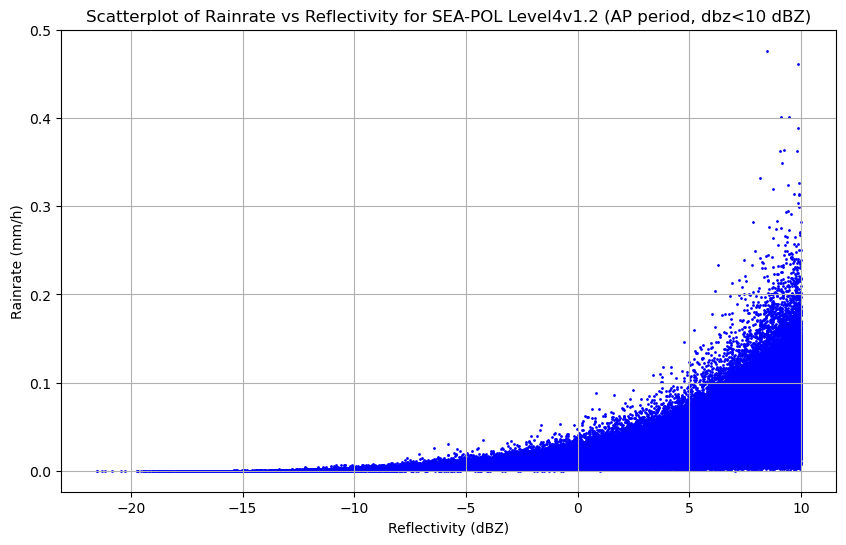

In [26]:

#scatterplot of rain rates where dbz<10
plt.figure(figsize=(10,6))
plt.scatter(dbz2[indexAP:-1,:,:].values[ilow],rainlow,s=1,color='blue',label='AP')
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.title('Scatterplot of Rainrate vs Reflectivity for SEA-POL Level4v1.2 (AP period, dbz<10 dBZ)')
plt.grid()
plt.show()

Issue with missing low rain rates has been fixed!

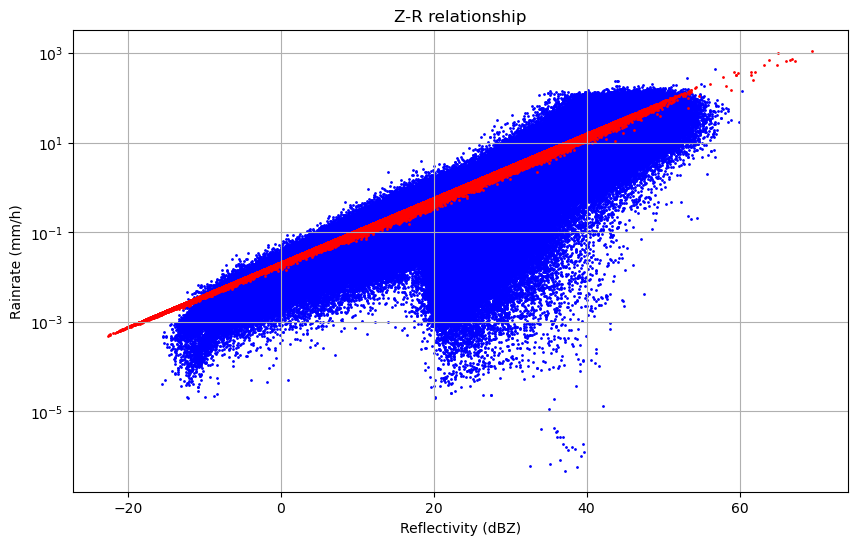

<Figure size 640x480 with 0 Axes>

In [28]:
#scatter plot of dbz vs rainrate
plt.figure(figsize=(10,6))
plt.scatter(dbz2[indexAP:-1,:,:].values.flatten(),rainrate2[indexAP:-1,:,:].values.flatten(),s=1,color='blue',label='AP')
plt.scatter(dbz2[0:indexBP,:,:].values.flatten(),rainrate2[0:indexBP,:,:].values.flatten(),s=1,color='red',label='BP')
#plt.legend()
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
#plt.ylim(100,1200)
plt.grid()
plt.title('Z-R relationship')
plt.show()

plt.savefig('../../figures/Fig_seapol_ZR_scatter_4v1.2.png')

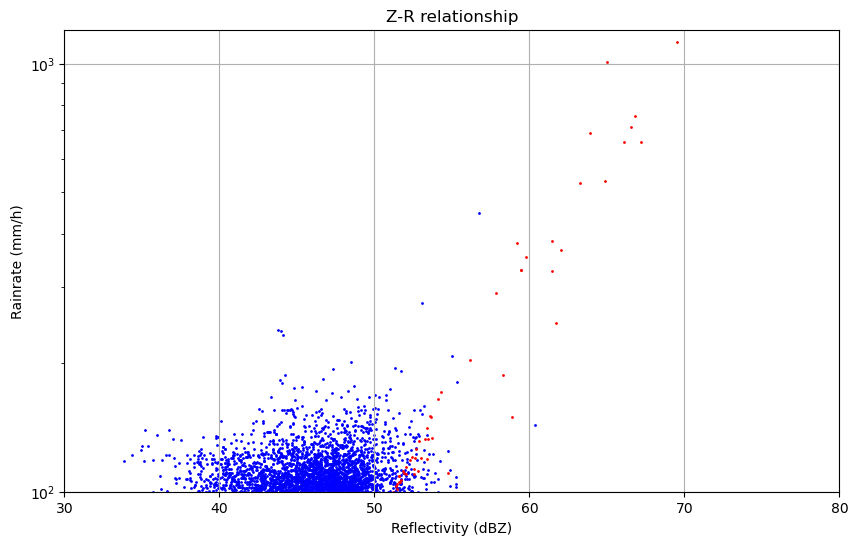

<Figure size 640x480 with 0 Axes>

In [29]:
#scatter plot of dbz vs rainrate
plt.figure(figsize=(10,6))
plt.scatter(dbz2[indexAP:-1,:,:].values.flatten(),rainrate2[indexAP:-1,:,:].values.flatten(),s=1,color='blue',label='AP')
plt.scatter(dbz2[0:indexBP,:,:].values.flatten(),rainrate2[0:indexBP,:,:].values.flatten(),s=1,color='red',label='BP')
#plt.legend()
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
plt.ylim(100,1200)
plt.xlim(30, 80)
plt.grid()
plt.title('Z-R relationship')
plt.show()

plt.savefig('../../figures/Fig_seapol_ZR_scatter_zoom_4v1.2.png')

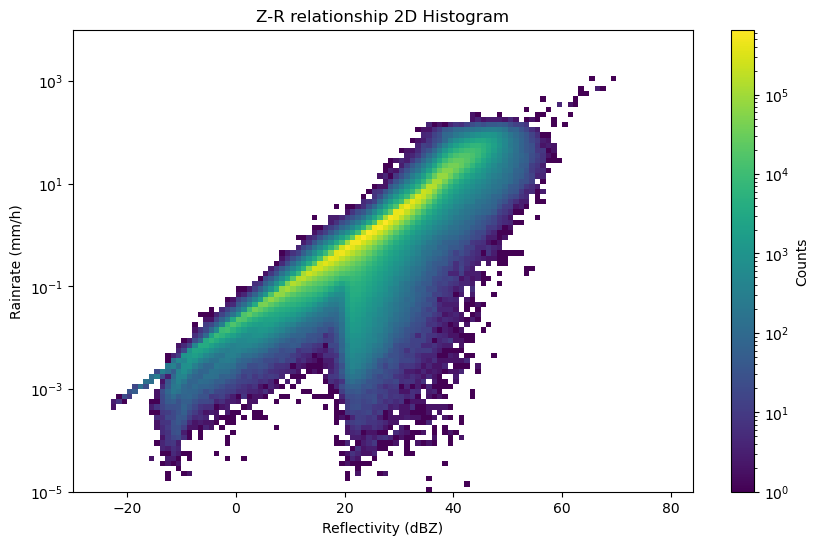

<Figure size 640x480 with 0 Axes>

In [33]:
# Prepare data for 2D histogram
dbz_flat = dbz2.values.flatten()
rainrate_flat = rainrate2.values.flatten()
#dbz_flat = dbz2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time
#rainrate_flat = rainrate2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time

# Filter out NaN values
mask = ~np.isnan(dbz_flat)
dbz_flat_filtered = dbz_flat[mask]
rainrate_flat_filtered = rainrate_flat[mask]

# Calculate 2D histogram
#pbins = np.concatenate((np.arange(0,1e-4,1e-5),np.arange(1e-4,1e-3,1e-4),np.arange(1e-3,0.01,1e-3),np.arange(0.01,0.1,0.01),np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100),np.arange(1000,10000,1000),np.arange(10000,100000,10000)))
pbins = np.concatenate(([0],np.power(10,np.arange(-5,5,0.1))))
dbzbins = np.arange(-30,85,1)
hist, xedges, yedges = np.histogram2d(dbz_flat_filtered, np.transpose(rainrate_flat_filtered), bins=[dbzbins, pbins],range=[[-30, 80], [0, 100000]])

# Plot 2D histogram
plt.figure(figsize=(10,6))
dbzmesh,pmesh = np.meshgrid(xedges, yedges)
plt.pcolormesh(dbzmesh, pmesh, hist.T, norm=LogNorm(), cmap='viridis', shading='auto')
#plt.imshow(hist.T, origin='lower', aspect='auto', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Counts')
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
plt.ylim(1e-5,1e4)
plt.title('Z-R relationship 2D Histogram')
plt.show()

plt.savefig('../../figures/Fig_seapol_ZR_heatmap_4v1.2.png')

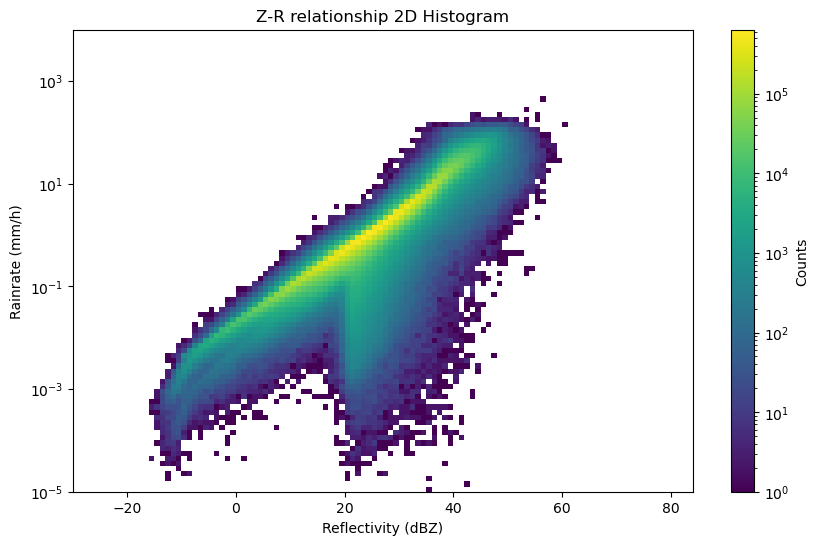

<Figure size 640x480 with 0 Axes>

In [34]:
# Prepare data for 2D histogram
#dbz_flat = dbz2.values.flatten()
#rainrate_flat = rainrate2.values.flatten()
dbz_flat = dbz2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time
rainrate_flat = rainrate2[indexAP:-1,:,:].values.flatten()  # Use only data after AP time

# Filter out NaN values
mask = ~np.isnan(dbz_flat)
dbz_flat_filtered = dbz_flat[mask]
rainrate_flat_filtered = rainrate_flat[mask]

# Calculate 2D histogram
#pbins = np.concatenate((np.arange(0,1e-4,1e-5),np.arange(1e-4,1e-3,1e-4),np.arange(1e-3,0.01,1e-3),np.arange(0.01,0.1,0.01),np.arange(0.1,1,0.1),np.arange(1,10,1),np.arange(10,100,10),np.arange(100,1000,100),np.arange(1000,10000,1000),np.arange(10000,100000,10000)))
pbins = np.concatenate(([0],np.power(10,np.arange(-5,5,0.1))))
dbzbins = np.arange(-30,85,1)
hist, xedges, yedges = np.histogram2d(dbz_flat_filtered, np.transpose(rainrate_flat_filtered), bins=[dbzbins, pbins],range=[[-30, 80], [0, 100000]])

# Plot 2D histogram
plt.figure(figsize=(10,6))
dbzmesh,pmesh = np.meshgrid(xedges, yedges)
plt.pcolormesh(dbzmesh, pmesh, hist.T, norm=LogNorm(), cmap='viridis', shading='auto')
#plt.imshow(hist.T, origin='lower', aspect='auto', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar(label='Counts')
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Rainrate (mm/h)')
plt.yscale('log')
plt.ylim(1e-5,1e4)
plt.title('Z-R relationship 2D Histogram')
plt.show()

plt.savefig('../../figures/Fig_seapol_ZR_heatmapAP_4v1.2.png')

# Plot time series

In [35]:
# Load spatial mean data
rain = xr.open_dataset('../../data/SEA-POL_4v1.2_rainrate_2D_spatial_means.nc')
rain5 = xr.open_dataset('../../data/SEA-POL_4v1.2_rainrate_2D_spatial_means_reg5.nc')
rain10 = xr.open_dataset('../../data/SEA-POL_4v1.2_rainrate_2D_spatial_means_reg10.nc')

/tmp/ipykernel_1519551/4292652833.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/4292652833.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.2, '−0.2'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4000000000000001, '0.4'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0000000000000002, '1.0'),
 Text(0, 1.2000000000000002, '1.2'),
 Text(0, 1.4000000000000001, '1.4')]

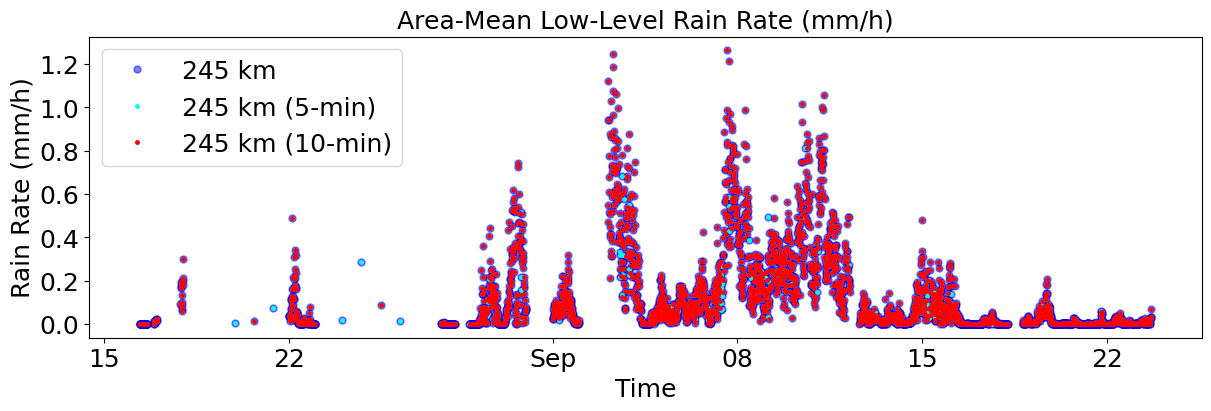

In [36]:
#Check different time grids

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain.time, rain.rain245_mean, 'o', markersize = '5', color='blue', alpha = 0.5, label='245 km')
ax.plot(rain5.time, rain5.rain245_mean, '.',markersize = '5', color='cyan', label='245 km (5-min)')
ax.plot(rain10.time, rain10.rain245_mean, '.',markersize = '5', color='red', label='245 km (10-min)')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

#ax.set_ylim(0, 4)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

most of the long range scns are on the 10-minute times, but there are a few on the 5s. 

/tmp/ipykernel_1519551/967607929.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/967607929.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.5, '−0.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0'),
 Text(0, 3.5, '3.5')]

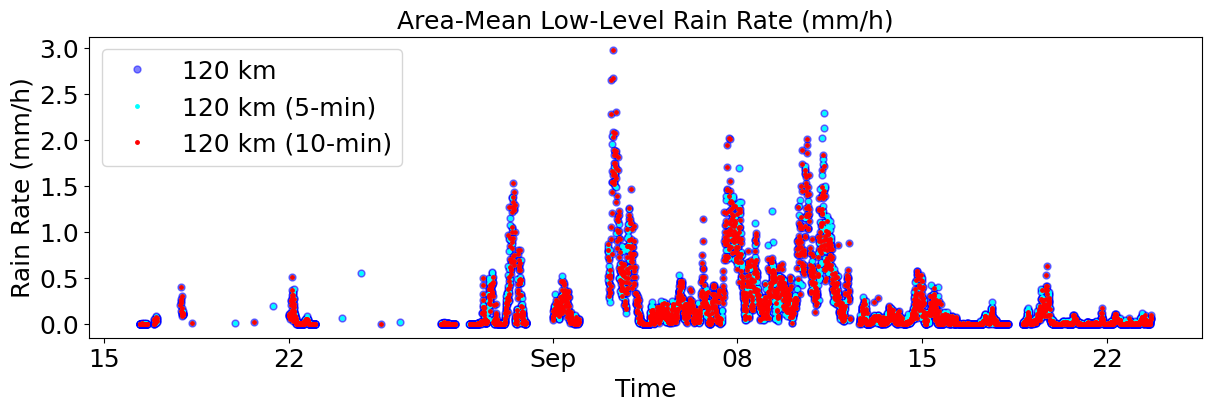

In [37]:
#Check different time grids

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain.time, rain.rain120_mean, 'o', markersize = '5', color='blue', alpha = 0.5, label='120 km')
ax.plot(rain5.time, rain5.rain120_mean, '.',markersize = '5', color='cyan', label='120 km (5-min)')
ax.plot(rain10.time, rain10.rain120_mean, '.',markersize = '5', color='red', label='120 km (10-min)')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

#ax.set_ylim(0, 4)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

using the 5 minute data gives more scans

/tmp/ipykernel_1519551/3700806300.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/3700806300.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.5, '−0.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0'),
 Text(0, 3.5, '3.5')]

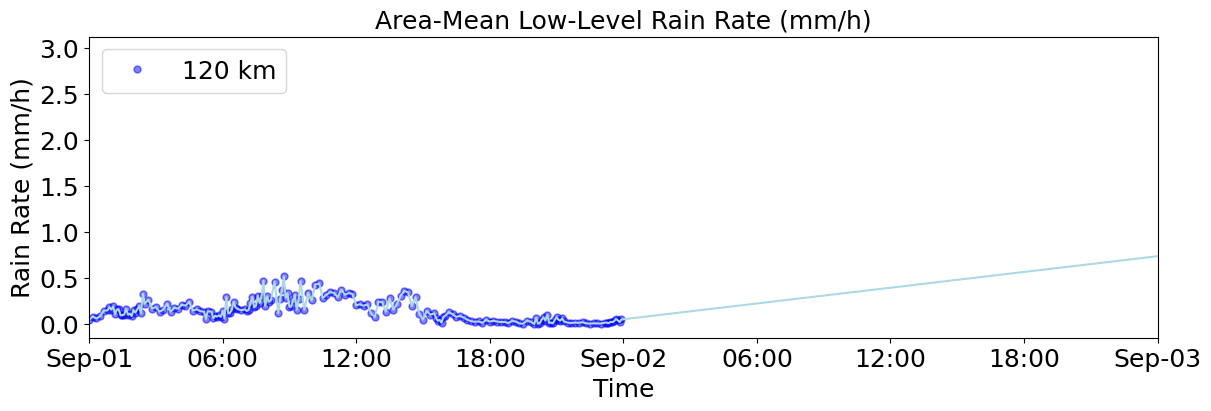

In [38]:
#Check different time grids

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain.time, rain.rain120_mean, 'o', markersize = '5', color='blue', alpha = 0.5, label='120 km')
ax.plot(rain.time, rain.rain120_mean, color='lightblue')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.set_xlim(np.datetime64('2024-09-01T00:00:00'), np.datetime64('2024-09-03T00:00:00'))

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

raw data connects all the points but also connects across missing data (it is not padded with NaNs)

/tmp/ipykernel_1519551/1197302509.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/1197302509.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.5, '−0.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0'),
 Text(0, 3.5, '3.5')]

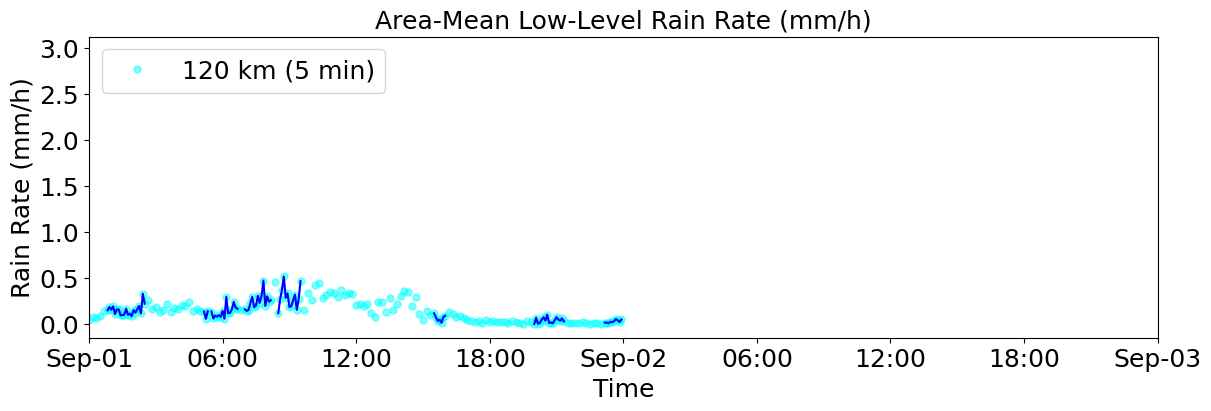

In [39]:
#Check different time grids

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain5.time, rain5.rain120_mean, 'o', markersize = '5', color='cyan', alpha = 0.5, label='120 km (5 min)')
ax.plot(rain5.time, rain5.rain120_mean, color='blue')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.set_xlim(np.datetime64('2024-09-01T00:00:00'), np.datetime64('2024-09-03T00:00:00'))

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

5 minute data weirdly does not connect all the points

In [40]:
rain5.rain120_mean.sel(time=slice('2024-09-01T00:00:00','2024-09-01T06:00:00'))

<xarray.DataArray 'rain120_mean' (time: 73)> Size: 292B
array([0.046535,      nan, 0.081215,      nan, 0.060568,      nan, 0.085587,
            nan, 0.146055,      nan, 0.148807, 0.18587 , 0.156343, 0.192538,
       0.107031, 0.158519, 0.159366, 0.09561 , 0.096956, 0.103732, 0.166831,
       0.10065 , 0.112924, 0.086762, 0.151086, 0.124498, 0.161272, 0.196809,
       0.114887, 0.329838, 0.220661,      nan, 0.265491,      nan, 0.168491,
            nan, 0.185523,      nan, 0.133993,      nan, 0.156219,      nan,
       0.221642,      nan, 0.135944,      nan, 0.176463,      nan, 0.16804 ,
            nan, 0.209801,      nan, 0.200149,      nan, 0.240442,      nan,
       0.146803,      nan, 0.160763,      nan, 0.140153,      nan, 0.134837,
       0.05603 , 0.139343,      nan, 0.134951, 0.060801, 0.090637, 0.080918,
       0.095297, 0.077982, 0.144093], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 584B 2024-09-01 ... 2024-09-01T06:00:00

Ohhhh I think it can't connect dots when it is alternating data and NaNs. Though it is weird there is so much missing data. I wonder if we were on CIRL/CIRC and it is just missing all that data on the 5s. Or some other schedule that put us off cycle. Ahh or we were running on a 10minute pattern (like NEAR, FAR etc..) rather than LONG+VOL1+VOL2, so there isn't a seperate scan on the 5s. That is probably actually mostly it. Or we were doing RHIs instead of VOL1. That is the case for Sept 1, it seems. 

/tmp/ipykernel_1519551/4090783790.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/4090783790.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -0.5, '−0.5'),
 Text(0, 0.0, '0.0'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.5, '1.5'),
 Text(0, 2.0, '2.0'),
 Text(0, 2.5, '2.5'),
 Text(0, 3.0, '3.0'),
 Text(0, 3.5, '3.5')]

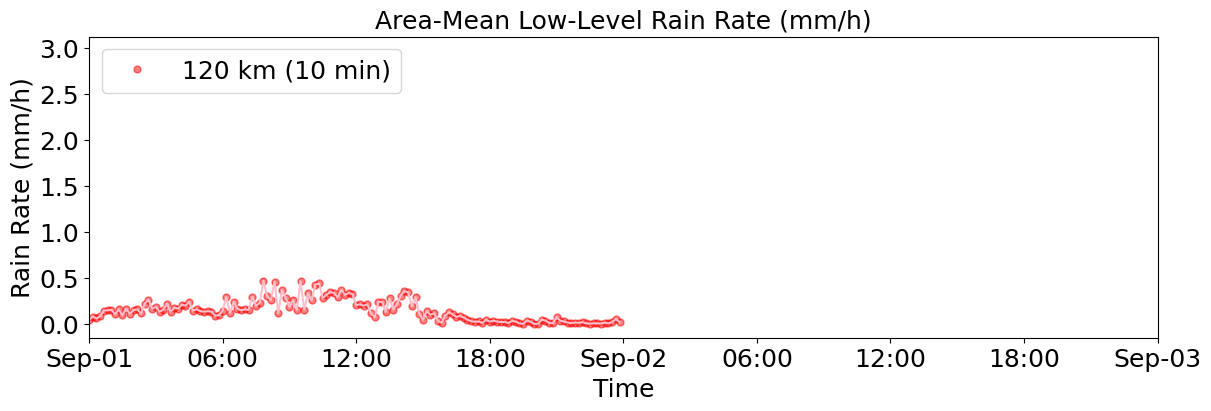

In [41]:
#Check different time grids

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain10.time, rain10.rain120_mean, 'o', markersize = '5', color='red', alpha = 0.5, label='120 km (10 min)')
ax.plot(rain10.time, rain10.rain120_mean, color='pink')
ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Rain Rate (mm/h)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.legend(loc='upper left', fontsize=18)

ax.set_xlim(np.datetime64('2024-09-01T00:00:00'), np.datetime64('2024-09-03T00:00:00'))

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

10-minute data connects all the dots fine

# Plots

/tmp/ipykernel_1519551/3685907532.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/3685907532.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -1.0, '−1'),
 Text(0, 0.0, '0'),
 Text(0, 1.0, '1'),
 Text(0, 2.0, '2'),
 Text(0, 3.0, '3'),
 Text(0, 4.0, '4'),
 Text(0, 5.0, '5'),
 Text(0, 6.0, '6'),
 Text(0, 7.0, '7')]

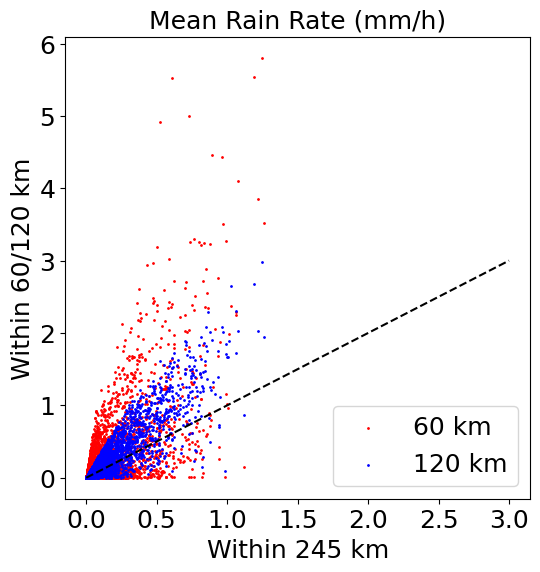

In [42]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain.rain245_mean, rain.rain60_mean,s=1,color='red',label='60 km')
ax.scatter(rain.rain245_mean, rain.rain120_mean,s=1,color='blue',label='120 km')

#Plot 1:1 line
x = np.linspace(0, 3, 100)
ax.plot(x, x, color='black', linestyle='--')

# legend
ax.legend(loc='lower right', fontsize=18)

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 60/120 km', fontsize=18)
ax.set_title('Mean Rain Rate (mm/h)', fontsize=18)

#ax.set_xlim(0,3)
#ax.set_ylim(0,3)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


/tmp/ipykernel_1519551/3392774290.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/3392774290.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


[Text(0, -10.0, '−10'),
 Text(0, 0.0, '0'),
 Text(0, 10.0, '10'),
 Text(0, 20.0, '20'),
 Text(0, 30.0, '30'),
 Text(0, 40.0, '40'),
 Text(0, 50.0, '50'),
 Text(0, 60.0, '60'),
 Text(0, 70.0, '70'),
 Text(0, 80.0, '80')]

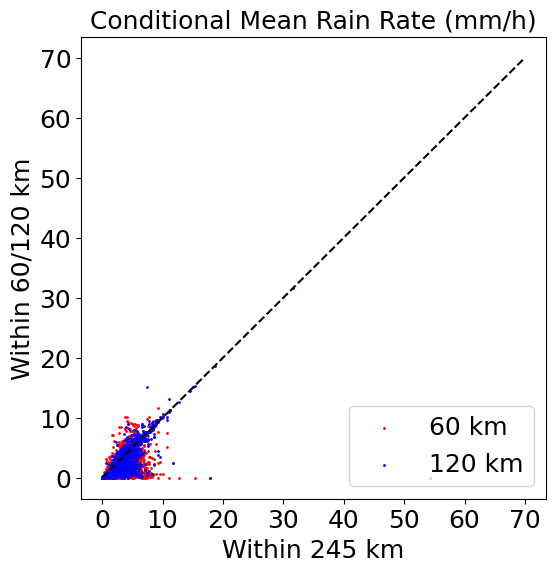

In [43]:
# make a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(rain.rain245_int, rain.rain60_int,s=1,color='red',label='60 km')
ax.scatter(rain.rain245_int, rain.rain120_int,s=1,color='blue',label='120 km')

#Plot 1:1 line
x = np.linspace(0, 70, 100)
ax.plot(x, x, color='black', linestyle='--')

# legend
ax.legend(loc='lower right', fontsize=18)

ax.set_xlabel('Within 245 km', fontsize=18)
ax.set_ylabel('Within 60/120 km', fontsize=18)

ax.set_title('Conditional Mean Rain Rate (mm/h)', fontsize=18)

#ax.set_xlim(0,30)
#ax.set_ylim(0,30)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# Extracting time series at specific times

In [50]:
# Search times
time1 = np.datetime64('2024-09-22T16:00:00')
time2 = np.datetime64('2024-09-23T16:00:00')

time3 = np.datetime64('2024-09-23T00:40:00')
time4 = np.datetime64('2024-09-23T07:00:00')
time5 = np.datetime64('2024-09-23T09:10:00')

#Find indices for start and end times
index1 = np.abs(pd.to_datetime(rain.time) - time1).argmin()
index2 = np.abs(pd.to_datetime(rain.time) - time2).argmin()
index3 = np.abs(pd.to_datetime(rain.time) - time3).argmin()
index4 = np.abs(pd.to_datetime(rain.time) - time4).argmin()
index5 = np.abs(pd.to_datetime(rain.time) - time5).argmin()

/tmp/ipykernel_1519551/1411512925.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_1519551/1411512925.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_1519551/1411512925.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)


[Text(1, -5.0, '−5'),
 Text(1, 0.0, '0'),
 Text(1, 5.0, '5'),
 Text(1, 10.0, '10'),
 Text(1, 15.0, '15'),
 Text(1, 20.0, '20'),
 Text(1, 25.0, '25'),
 Text(1, 30.0, '30')]

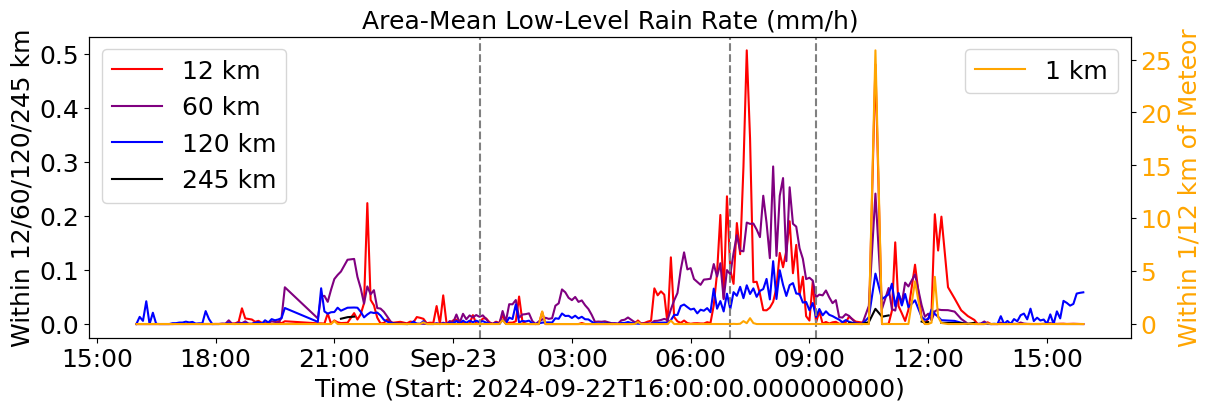

In [51]:
# make plot
fig,ax = plt.subplots(figsize=(12,4),layout="constrained")
ax.plot(rain.time[index1:index2], rain.rain12_mean[index1:index2].values, color='red', label='12 km')
ax.plot(rain.time[index1:index2], rain.rain60_mean[index1:index2].values, color='purple', label='60 km')
ax.plot(rain.time[index1:index2], rain.rain120_mean[index1:index2].values, color='blue', label='120 km')
ax.plot(rain.time[index1:index2], rain.rain245_mean[index1:index2].values, color='black', label='245 km')

#plot vertical line at time index3
ax.axvline(x=rain.time[index3].values, color='gray', linestyle='--')
ax.axvline(x=rain.time[index4].values, color='gray', linestyle='--')
ax.axvline(x=rain.time[index5].values, color='gray', linestyle='--')

ax.set_title('Area-Mean Low-Level Rain Rate (mm/h)',fontsize=18)
ax.set_ylabel('Within 12/60/120/245 km', fontsize=18)
ax.set_xlabel(f"Time (Start: {rain.time[index1].values})",fontsize=18)
#ax.set_ylim(0, 4)

ax.legend(loc='upper left', fontsize=18)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax2 = ax.twinx()
ax2.plot(rain.time[index1:index2], rain.rain1_mean[index1:index2].values, color='orange', label='1 km')
#ax2.plot(rain.time[index1:index2], rain.rain12_mean[index1:index2].values, color='red', label='12 km')
#ax2.set_ylim(0,15)
ax2.set_ylabel('Within 1/12 km of Meteor',color='orange',fontsize=18)

ax2.legend(loc='upper right', fontsize=18)
ax2.tick_params(axis='y',labelcolor='orange')
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=18)

In [52]:
# Search times
timesearch = np.datetime64('2024-09-23T00:40:00')

#Find indices for start and end times
index = np.abs(pd.to_datetime(rain.time) - timesearch).argmin()
index

np.int64(5640)

In [53]:
indexX = np.abs(seapol.X - -12000).argmin()
indexX = np.abs(seapol.X - 12000).argmin()
indexX

<xarray.DataArray 'X' ()> Size: 8B
array(257)

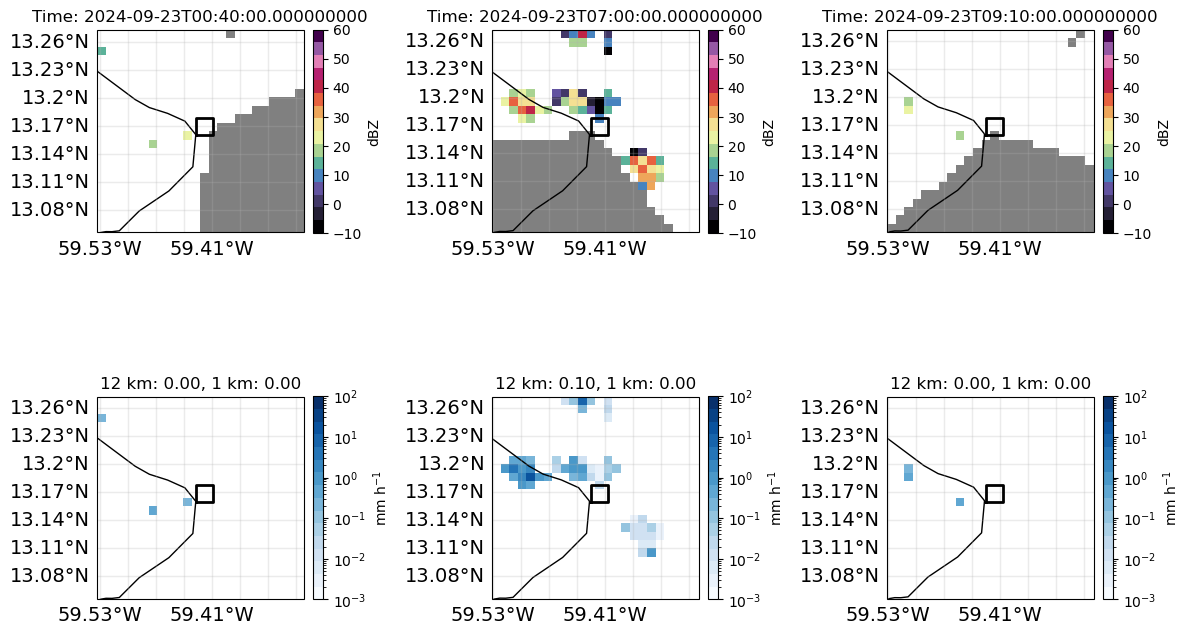

In [54]:
#proj = ccrs.TransverseMercator(central_longitude=seapol.longitude[4390,245,245].values, central_latitude=seapol.latitude[4390,245,245].values)
proj = ccrs.PlateCarree()   

fig, axes = plt.subplots(2, 3, figsize=(12,8),subplot_kw={'projection': proj})

rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap = ListedColormap(rain_cmap(np.linspace(0, 1, 16)))
rain_cmap.set_under(color='white') #set values below vmin to white
rain_cmap.set_over(color='red') #set values above vmax to blue

gl = axes[0,0].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[0,1].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[0,2].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[1,0].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[1,1].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

gl = axes[1,2].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

axes[1,0].pcolormesh(seapol.longitude[index3,233:257,233:257], seapol.latitude[index3,233:257,233:257], rainrate4[index3,233:257,233:257], cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=100))
axes[1,1].pcolormesh(seapol.longitude[index4,233:257,233:257], seapol.latitude[index4,233:257,233:257], rainrate4[index4,233:257,233:257], cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=100))
axes[1,2].pcolormesh(seapol.longitude[index5,233:257,233:257], seapol.latitude[index5,233:257,233:257], rainrate4[index5,233:257,233:257], cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=100))

axes[0,0].pcolormesh(seapol.longitude[index3,233:257,233:257], seapol.latitude[index3,233:257,233:257], dbz[index3,233:257,233:257], cmap=discrete_mask_cmap, vmin=-10, vmax=60)
axes[0,1].pcolormesh(seapol.longitude[index4,233:257,233:257], seapol.latitude[index4,233:257,233:257], dbz[index4,233:257,233:257], cmap=discrete_mask_cmap, vmin=-10, vmax=60)
axes[0,2].pcolormesh(seapol.longitude[index5,233:257,233:257], seapol.latitude[index5,233:257,233:257], dbz[index5,233:257,233:257], cmap=discrete_mask_cmap, vmin=-10, vmax=60)

fig.tight_layout()

#draw a 1 km box
x_start = seapol.longitude[index3,245,244].values
x_end = seapol.longitude[index3,245,246].values
y_start = seapol.latitude[index3,244,245].values
y_end = seapol.latitude[index3,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[0,0].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index4,245,244].values
x_end = seapol.longitude[index4,245,246].values
y_start = seapol.latitude[index4,244,245].values
y_end = seapol.latitude[index4,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[0,1].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index5,245,244].values
x_end = seapol.longitude[index5,245,246].values
y_start = seapol.latitude[index5,244,245].values
y_end = seapol.latitude[index5,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[0,2].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index3,245,244].values
x_end = seapol.longitude[index3,245,246].values
y_start = seapol.latitude[index3,244,245].values
y_end = seapol.latitude[index3,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[1,0].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index4,245,244].values
x_end = seapol.longitude[index4,245,246].values
y_start = seapol.latitude[index4,244,245].values
y_end = seapol.latitude[index4,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[1,1].plot(*box_coord, color='black', linewidth=2)

x_start = seapol.longitude[index5,245,244].values
x_end = seapol.longitude[index5,245,246].values
y_start = seapol.latitude[index5,244,245].values
y_end = seapol.latitude[index5,246,245].values
box_coord = ((x_start, x_end, x_end, x_start, x_start),(y_start, y_start, y_end, y_end, y_start))
axes[1,2].plot(*box_coord, color='black', linewidth=2)

axes[0,0].set_title(f'Time: {rain.time[index3].values}', fontsize=12)
axes[0,1].set_title(f'Time: {rain.time[index4].values}', fontsize=12) 
axes[0,2].set_title(f'Time: {rain.time[index5].values}', fontsize=12)

axes[1,0].set_title(f'12 km: {rain.rain12_mean[index3].values:.2f}, 1 km: {rain.rain1_mean[index3].values:.2f}', fontsize=12)
axes[1,1].set_title(f'12 km: {rain.rain12_mean[index4].values:.2f}, 1 km: {rain.rain1_mean[index4].values:.2f}', fontsize=12)
axes[1,2].set_title(f'12 km: {rain.rain12_mean[index5].values:.2f}, 1 km: {rain.rain1_mean[index5].values:.2f}', fontsize=12)

cbar = fig.colorbar(axes[0,0].collections[0], ax=axes[0,0], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('dBZ')

cbar = fig.colorbar(axes[0,1].collections[0], ax=axes[0,1], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('dBZ')

cbar = fig.colorbar(axes[0,2].collections[0], ax=axes[0,2], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('dBZ')

cbar = fig.colorbar(axes[1,0].collections[0], ax=axes[1,0], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('mm h$^{-1}$')

cbar = fig.colorbar(axes[1,1].collections[0], ax=axes[1,1], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('mm h$^{-1}$')

cbar = fig.colorbar(axes[1,2].collections[0], ax=axes[1,2], orientation='vertical', fraction=0.045, pad=0.04)
cbar.set_label('mm h$^{-1}$')

axes[0,0].coastlines()
axes[0,1].coastlines()
axes[0,2].coastlines()
axes[1,0].coastlines()
axes[1,1].coastlines()
axes[1,2].coastlines()

fig.tight_layout()

Light rain that was gone in v1.1 has returned, hooray